
# Principal Component Analysis (PCA): An Introduction *(Unsupervised Learning)*

**Audience:** First-year MSc students in Economics & Finance  
**Duration:** ~45–60 minutes  
**Learning goals:**  
- Understand PCA as a method for unsupervised learning and dimensionality reduction.  
- Know the core linear algebra and statistical ideas behind PCA.  
- Apply PCA in Python to realistic econ/finance-style datasets.  
- Interpret loadings, scores, explained variance, and reconstruction.  
- Recognize common pitfalls (scaling, outliers, interpretability).

**Dependencies:** `numpy`, `pandas`, `matplotlib`, `scikit-learn`



## 1. Unsupervised Learning and Where PCA Fits

In **unsupervised learning**, we observe a dataset $X \in \mathbb{R}^{n \times p}$ with $n$ observations and $p$ variables, but **no labels** (no explicit target $y$).  
The goal is to **discover structure** in the data—clusters, low-dimensional manifolds, or latent factors.

**PCA** is a classical unsupervised method that:
- finds orthogonal directions (principal components) capturing the **maximal variance** of the data;
- provides a **low-dimensional representation** with minimal reconstruction error in the least-squares sense;
- is widely used in **econometrics** (e.g., factor models), **portfolio analysis**, and **macro** (e.g., yield-curve factors).



## 2. PCA Theory (Core Ideas)

Let $X \in \mathbb{R}^{n \times p}$ be the (column-)**centered** data matrix, i.e. each variable has zero mean.  
Define the **sample covariance**:

$$
S = \frac{1}{n-1} X^\top X \;\in\; \mathbb{R}^{p \times p}.
$$

Compute the **eigendecomposition** $S v_j = \lambda_j v_j$ with eigenvalues $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_p \ge 0$ and orthonormal eigenvectors $v_j$.  
The **$j$-th principal component direction** is $v_j$, and the **scores** (principal component values) are

$$
Z = X V \quad \text{where } V = [v_1,\dots,v_p].
$$

**Explained variance ratio** (EVR) of component $j$:

$$
\mathrm{EVR}_j = \frac{\lambda_j}{\sum_{k=1}^p \lambda_k}, 
\qquad 
\mathrm{cumulative\ EVR}(k) = \sum_{j=1}^k \mathrm{EVR}_j.
$$

**SVD view.** PCA is equivalent to the SVD of $X$: $X = U \Sigma V^\top$. The columns of $V$ are principal directions; scores are $Z = U\Sigma$.  

**Best rank-$k$ approximation** (Eckart–Young–Mirsky): the projection onto the first $k$ components minimizes

$$
\| X - \hat{X}_k \|_F^2 = \sum_{j=k+1}^{p} \sigma_j^2,
$$

where $\sigma_j$ are singular values.

**Scaling.** If variables are on very different scales, apply **standardization** (z-scores) so PCA approximates eigenvectors of the **correlation** matrix instead of the covariance matrix.

**Choosing $k$.** Common heuristics: scree plot (elbow), cumulative EVR (e.g., 90–95%), cross-validation on downstream tasks, or domain knowledge.


In [1]:

# --- Setup: imports and reproducibility ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.random.seed(42)
pd.set_option("display.precision", 4)

# Matplotlib display defaults (optional)
plt.rcParams['figure.figsize'] = (7, 4.5)


In [2]:

# --- Plotting helpers (Matplotlib only, no seaborn) ---

def plot_scree(pca, title="Scree Plot: Explained Variance by Component"):
    evr = pca.explained_variance_ratio_
    fig = plt.figure()
    plt.plot(np.arange(1, len(evr)+1), evr, marker="o")
    plt.xlabel("Component index")
    plt.ylabel("Explained variance ratio")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_cumulative_evr(pca, title="Cumulative Explained Variance"):
    cum = np.cumsum(pca.explained_variance_ratio_)
    fig = plt.figure()
    plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
    plt.axhline(0.9, linestyle="--")
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative EVR")
    plt.title(title)
    plt.grid(True)
    plt.show()

def biplot(scores, loadings, feature_names=None, title="Biplot (PC1 vs PC2)", scale_scores=1.0, scale_loadings=1.0):
    # scores: (n, 2) matrix of PC scores for the first two components
    # loadings: (p, 2) matrix of loadings for the first two components
    fig = plt.figure()
    plt.scatter(scores[:, 0]*scale_scores, scores[:, 1]*scale_scores, alpha=0.6)
    for i in range(loadings.shape[0]):
        x = loadings[i, 0]*scale_loadings
        y = loadings[i, 1]*scale_loadings
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.03, linewidth=1, length_includes_head=True)
        if feature_names is not None:
            plt.text(x*1.08, y*1.08, feature_names[i], fontsize=8)
    plt.axhline(0, linewidth=0.5)
    plt.axvline(0, linewidth=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(True)
    plt.show()



## 3. Example A — Asset Returns with Latent Factors

We simulate $T=500$ daily returns for $N=50$ assets driven by $K=3$ latent factors (e.g., market, size, momentum) with idiosyncratic noise.  
We expect the first few PCs to explain a large share of the variance (as in factor models).


In [3]:

# --- Simulate factor-driven asset returns ---
T = 500     # time points (observations)
N = 50      # assets (features)
K_true = 3  # latent factors

# latent factors (T x K)
F = np.random.normal(size=(T, K_true))
# smoother factors for realism
for k in range(K_true):
    F[:, k] = np.convolve(F[:, k], np.ones(5)/5, mode='same')

# loadings (N x K)
L = np.random.normal(scale=0.5, size=(N, K_true))
# add structure: first PC loads broadly ("market"), others more selective
L[:, 0] += 1.0 * np.random.choice([1, -1], size=N)

# idiosyncratic noise
E = 0.5 * np.random.normal(size=(T, N))

# returns matrix: X_raw (T x N)
X_raw = F @ L.T + E

asset_names = [f"Asset_{i:02d}" for i in range(N)]
df_returns = pd.DataFrame(X_raw, columns=asset_names)
df_returns.head()


,Asset_00,Asset_01,Asset_02,Asset_03,Asset_04,Asset_05,Asset_06,Asset_07,Asset_08,Asset_09,...,Asset_40,Asset_41,Asset_42,Asset_43,Asset_44,Asset_45,Asset_46,Asset_47,Asset_48,Asset_49
0,1.3645,-0.0967,-1.1911,0.3899,-1.1026,-0.0948,0.4366,0.9935,0.8045,-0.5725,...,-0.9586,0.9226,0.7070,1.2091,-0.4645,-1.1685,1.7495,1.0291,0.5252,-0.6555
1,0.7418,-0.7590,-1.4936,-0.3466,-1.9113,-0.5324,0.8528,0.6890,0.7826,0.3222,...,-0.6074,0.5541,1.3703,1.5279,0.0610,-0.9575,1.6358,1.2979,0.1753,-1.6671
2,1.4008,-1.7766,-0.5546,-0.5793,-1.2496,-1.7064,-0.3165,1.3957,0.6166,-0.1406,...,0.0122,-0.2755,0.6675,1.2604,-0.6745,-0.3810,2.5750,0.5429,0.4715,-0.8822
3,1.4830,-0.1822,-0.6999,-0.1700,-1.1973,-1.6232,0.8189,0.9278,-1.2357,0.6430,...,0.1016,-0.9626,-0.6817,1.6646,-0.1410,-0.8666,1.6263,0.4671,0.2404,-1.5823
4,0.4916,0.1342,-1.0587,0.2501,-0.3843,-1.0332,-0.8150,0.5210,-0.3399,0.7069,...,-0.4315,-0.6114,-0.2511,1.0184,-0.8031,0.2734,0.4588,0.7338,-0.1349,-1.3839



### 3.1 Standardize and Fit PCA

With returns, variables (assets) are already comparable in scale; still, standardizing columns (z-scores) is common so each asset has zero mean and unit variance.


In [4]:

# --- Standardize (column-wise) and run PCA ---
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(df_returns.values)  # (T x N)

pca = PCA(n_components=N, svd_solver="full", random_state=42)
Z = pca.fit_transform(X)   # scores (T x N)
V = pca.components_.T      # loadings/directions (N x N), columns = components

explained = pca.explained_variance_ratio_
pd.Series(explained[:10], index=[f"PC{i+1}" for i in range(10)], name="EVR (first 10)")


PC1     0.3336
PC2     0.1540
PC3     0.0750
PC4     0.0199
PC5     0.0191
PC6     0.0173
PC7     0.0166
PC8     0.0160
PC9     0.0154
PC10    0.0147
Name: EVR (first 10), dtype: float64

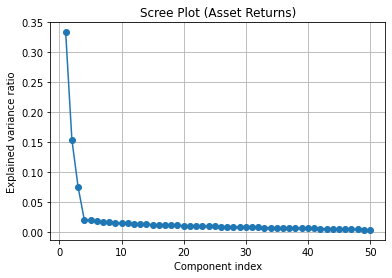

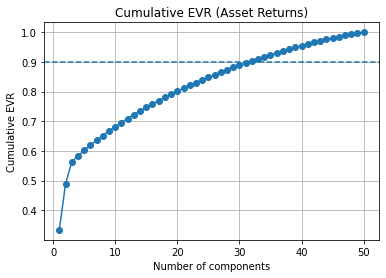

In [5]:

# --- Scree and cumulative EVR ---
plot_scree(pca, title="Scree Plot (Asset Returns)")
plot_cumulative_evr(pca, title="Cumulative EVR (Asset Returns)")



### 3.2 Interpreting Loadings and Scores

- **Loadings** (columns of $V$) show how each asset contributes to a principal component.  
- **Scores** $Z$ are the time-series of the principal components.

Below: the top 10 assets by absolute loading on PC1.


In [6]:

# --- Top assets by loading on PC1 ---
pc1_load = V[:, 0]
order = np.argsort(-np.abs(pc1_load))[:10]
top_pc1 = pd.DataFrame({
    "asset": np.array(asset_names)[order],
    "loading_PC1": pc1_load[order]
}).reset_index(drop=True)
top_pc1


,asset,loading_PC1
0,Asset_13,0.2161
1,Asset_46,-0.2041
2,Asset_47,-0.2009
3,Asset_37,0.1981
4,Asset_33,0.1885
5,Asset_35,0.1879
6,Asset_07,-0.1855
7,Asset_39,0.1832
8,Asset_00,-0.1821
9,Asset_43,-0.1816


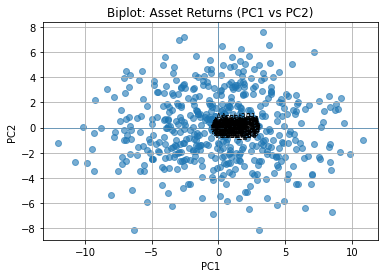

In [7]:

# --- Biplot for PC1 vs PC2 ---
scores_12 = Z[:, :2]
loads_12 = V[:, :2]
biplot(scores_12, loads_12, feature_names=asset_names, 
       title="Biplot: Asset Returns (PC1 vs PC2)", scale_scores=1.0, scale_loadings=2.5)



## 4. Example B — Yield Curve (Level, Slope, Curvature)

A classic result is that government yield curves are well-described by three components: **level**, **slope**, and **curvature**.  
We simulate synthetic yields for $M=10$ maturities and $T=300$ days from a 3-factor structure and recover them via PCA.


In [8]:

# --- Simulate synthetic yields ---
T2 = 300
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])  # in years
M = len(maturities)

# latent factors: level, slope, curvature
level = 2.0 + 0.1*np.sin(np.linspace(0, 10, T2))
slope = -0.5 + 0.2*np.cos(np.linspace(0, 5, T2))
curv  = 0.3*np.sin(np.linspace(0, 8, T2))

# factor loadings by maturity
L_level = np.ones(M)
L_slope = -(maturities - maturities.mean()) / maturities.ptp()
L_curv  = -((maturities - maturities.mean())**2) / (maturities.ptp()**2) + 0.5

# construct yields + noise
Y = np.outer(level, L_level) + np.outer(slope, L_slope) + np.outer(curv, L_curv)
Y += 0.03 * np.random.normal(size=Y.shape)  # small noise

yield_cols = [f"{m}y" for m in maturities]
df_yields = pd.DataFrame(Y, columns=yield_cols)
df_yields.head()


,0.25y,0.5y,1.0y,2.0y,3.0y,5.0y,7.0y,10.0y,20.0y,30.0y
0,1.9576,1.9122,1.9441,1.9444,1.9475,1.9560,2.0502,2.1052,2.0958,2.1910
1,1.9312,1.8643,1.9390,2.0080,1.9400,2.0107,2.0426,2.0029,2.1337,2.2367
2,1.9586,1.9634,1.9782,1.9314,1.9703,2.0300,2.0536,2.0428,2.1184,2.2601
3,1.9596,1.9616,1.9746,1.9333,1.9976,1.9974,2.0474,2.0440,2.1579,2.2458
4,1.9339,1.9259,1.9824,1.9431,1.9692,1.9890,2.0315,2.0709,2.0998,2.2133


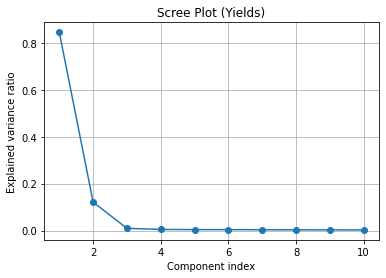

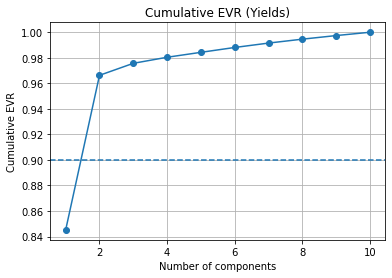

In [9]:

# --- Standardize across maturities and PCA ---
scaler_y = StandardScaler()
Y_std = scaler_y.fit_transform(df_yields.values)

pca_y = PCA(n_components=M, svd_solver="full", random_state=42)
Zy = pca_y.fit_transform(Y_std)
Vy = pca_y.components_.T

plot_scree(pca_y, title="Scree Plot (Yields)")
plot_cumulative_evr(pca_y, title="Cumulative EVR (Yields)")


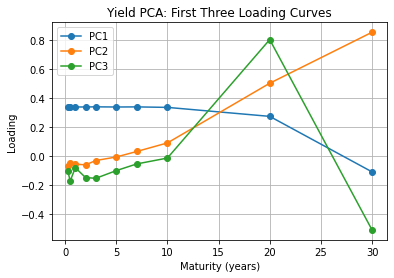

In [10]:

# --- Inspect first three loading shapes vs maturity ---
fig = plt.figure()
for j in range(3):
    plt.plot(maturities, Vy[:, j], marker="o", label=f"PC{j+1}")
plt.xlabel("Maturity (years)")
plt.ylabel("Loading")
plt.title("Yield PCA: First Three Loading Curves")
plt.grid(True)
plt.legend()
plt.show()



**Interpretation:**  
- **PC1** typically resembles *level* (roughly constant across maturities).  
- **PC2** resembles *slope* (positive at short end, negative at long end, or vice versa).  
- **PC3** resembles *curvature* (hump-shaped).

This aligns with macro-finance evidence that a small number of factors explain most yield-curve movements.



## 5. Reconstruction and Approximation Error

Given $X$ and PCA with directions $V$, the **rank-$k$ reconstruction** is

$$
\hat{X}_k = Z_k V_k^\top,
$$

where $Z_k$ are the first $k$ scores and $V_k$ the first $k$ directions.  
The **Frobenius reconstruction error** satisfies

$$
\lVert X - \hat{X}_k \rVert_F^2 = \sum_{j=k+1}^{p} \sigma_j^2.
$$

Below we compute reconstruction error as a function of $k$ for the returns example.


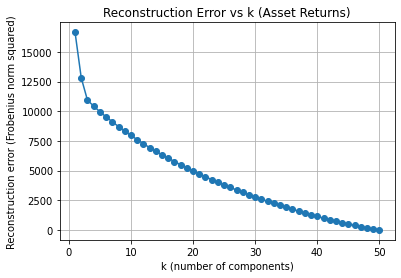

In [11]:

# --- Reconstruction error vs k (asset returns) ---
errs = []
for k in range(1, N+1):
    Uk = Z[:, :k]               # (T x k)
    Vk = V[:, :k]               # (N x k)
    Xk = Uk @ Vk.T              # (T x N)
    err = np.linalg.norm(X - Xk, ord='fro')**2
    errs.append(err)

fig = plt.figure()
plt.plot(range(1, N+1), errs, marker="o")
plt.xlabel("k (number of components)")
plt.ylabel("Reconstruction error (Frobenius norm squared)")
plt.title("Reconstruction Error vs k (Asset Returns)")
plt.grid(True)
plt.show()



## 6. Practical Considerations

- **Centering and scaling:** Center columns; scale if units differ. Using `StandardScaler` makes PCA approximate eigenvectors of the **correlation** matrix.
- **Outliers:** PCA is least-squares optimal but sensitive to outliers. Consider robust scaling or outlier detection before PCA.
- **Interpretability:** Components are linear combinations of variables; rotation (e.g., varimax) or sparse PCA can aid interpretation.
- **Missing data:** Impute (e.g., mean, KNN) before PCA or use methods that handle missingness.
- **Choosing $k$:** Use scree, cumulative EVR, or downstream task performance.
- **Computation:** For large $n,p$, use `svd_solver="randomized"` in `sklearn` to speed up estimation.
- **Whitening:** Setting `whiten=True` scales scores to unit variance; useful in some pipelines but changes the metric.



## 7. Using `scikit-learn` PCA Correctly

A minimal pattern:


In [12]:

from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    PCA(n_components=0.95, svd_solver="full", random_state=42)  # keep 95% variance
)

pipe.fit(df_returns.values)
pca_model = pipe.named_steps["pca"]
pca_model.explained_variance_ratio_.cumsum()[:10]


array([0.33363882, 0.48763071, 0.56266242, 0.5825955 , 0.60164908,
       0.61895507, 0.63554704, 0.65156394, 0.66692703, 0.68159489])


## 8. Exercises (with Solutions)

Work through the following short exercises. Try to implement your answer in the **Exercise** cell first, then reveal/execute the **Solution** cell.



### Exercise 1 — Standardize and PCA on Returns
**Task:** Using `df_returns`, standardize the columns, fit PCA, and report how many components are needed to explain **90%** of the variance.


In [13]:

# --- Exercise 1 (your code) ---
# TODO: compute number of components for 90% EVR
# Hint: StandardScaler -> PCA -> np.argmax(np.cumsum(evr) >= 0.90) + 1


In [14]:

# --- Solution 1 ---
sc = StandardScaler()
X_ex1 = sc.fit_transform(df_returns.values)
pca_ex1 = PCA().fit(X_ex1)
k90 = np.argmax(np.cumsum(pca_ex1.explained_variance_ratio_) >= 0.90) + 1
print("Number of components for 90% EVR =", k90)


Number of components for 90% EVR = 32



### Exercise 2 — Reconstruction Error
**Task:** For the returns data, reconstruct $X$ using the first $k=3$ components and compute the squared Frobenius error $\|X - \hat{X}_3\|_F^2$.


In [15]:

# --- Exercise 2 (your code) ---
# TODO: use Z (scores) and V (loadings) from earlier PCA fit; compute reconstruction with k=3


In [16]:

# --- Solution 2 ---
k = 3
Uk = Z[:, :k]
Vk = V[:, :k]
Xk = Uk @ Vk.T
err_k = np.linalg.norm(X - Xk, ord='fro')**2
print("Squared Frobenius reconstruction error (k=3):", float(err_k))


Squared Frobenius reconstruction error (k=3): 10933.439470968951



### Exercise 3 — Yield PCA Interpretation
**Task:** Using the yield PCA `pca_y`, check the signs and shapes of the first three loading vectors against maturities.  
**Question:** Which corresponds to level, slope, and curvature in your simulation?


In [17]:

# --- Exercise 3 (your code) ---
# TODO: inspect Vy[:, :3] vs maturities; comment based on the shapes.


In [18]:

# --- Solution 3 (illustration) ---
for j in range(3):
    print(f"PC{j+1} loading (first 5 values):", np.round(Vy[:5, j], 3))
print("Interpretation: PC1 ~ level (nearly flat); PC2 ~ slope (monotone across maturities); PC3 ~ curvature (hump).")


PC1 loading (first 5 values): [0.337 0.338 0.338 0.338 0.339]
PC2 loading (first 5 values): [-0.065 -0.046 -0.054 -0.059 -0.029]
PC3 loading (first 5 values): [-0.099 -0.169 -0.079 -0.147 -0.152]
Interpretation: PC1 ~ level (nearly flat); PC2 ~ slope (monotone across maturities); PC3 ~ curvature (hump).



### (Optional) Exercise 4 — Randomized SVD
**Task:** Re-run PCA on the returns using `svd_solver="randomized"` with `n_components=10`.  
Compare the first 10 EVRs to the full SVD solution.


In [19]:

# --- Exercise 4 (your code) ---
# TODO: PCA(n_components=10, svd_solver="randomized") and compare explained variance ratios.


In [20]:

# --- Solution 4 ---
pca_full = PCA(n_components=10, svd_solver="full", random_state=42).fit(X)
pca_rand = PCA(n_components=10, svd_solver="randomized", random_state=42).fit(X)
print("Full SVD EVR (first 10):", np.round(pca_full.explained_variance_ratio_, 4))
print("Randomized SVD EVR (first 10):", np.round(pca_rand.explained_variance_ratio_, 4))


Full SVD EVR (first 10): [0.3336 0.154  0.075  0.0199 0.0191 0.0173 0.0166 0.016  0.0154 0.0147]
Randomized SVD EVR (first 10): [0.3336 0.154  0.075  0.0199 0.019  0.0173 0.0166 0.016  0.0153 0.0144]



## 9. Summary

- PCA finds orthogonal directions of maximal variance.  
- Use standardized data when scales differ.  
- Inspect **scree** and **cumulative EVR** to choose $k$.  
- Interpret loadings carefully; signs can flip without changing the subspace.  
- In econ/finance, PCA connects to latent factor models, portfolio risk, and yield-curve analysis.

**Next steps:** explore kernel PCA, sparse PCA, or dynamic factor models; try PCA on real datasets (macro panels, high-dimensional returns).
